In [1]:
import numpy as np

def n_body(t,x,p):
    """
    ODE function for the n-body problem.

    Parameters:
    t (float): time (unused but required for ODE solver compatibility)
    x (np.array): state vector containing positions and velocities
    p (dict): parameters dictionary containing:
        - m (list): masses of particles
        - G (float): gravitational constant
        - dimension (int): number of spatial dimensions
        - fix_first (bool): whether to fix the first particle in place

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # Extract parameters
    masses = np.array(p['m'])
    G = p['G']
    dimensions = p['dimension']
    n_bodies = len(masses)

    # Initialize derivative vector
    dxdt = np.zeros_like(x)

    # First half of dxdt is just the velocities from second half of x
    dxdt[:n_bodies*dimensions] = x[n_bodies*dimensions:]  # n_bodies = 3, dimensions = 2; dxdt[0:6] = x[6:12]

    # Initialize force matrices for each dimension
    force_matrices = np.zeros((dimensions, n_bodies, n_bodies))

    # Calculate forces between all pairs of bodies
    for i in range(n_bodies):
        for j in range(i+1, n_bodies):  # Only upper triangle

            # Calculate displacement vector between bodies i and j
            r_ij = []  # x, y
            for d in range(dimensions):
                displacement = x[i*dimensions + d] - x[j*dimensions + d]
                # print(f"Displacement between body {i} and body {j} in dimension {d}: {displacement}")
                r_ij.append(displacement)

            r_ij = np.array(r_ij)  # x, y displacement

            # Calculate distance
            r = np.sqrt(np.sum(r_ij**2) + 1e-10)  # Add small number to avoid division by zero
            # print(f"Distance between body {i} and body {j}: {r}")

            # Calculate gravitational force magnitude
            force_mag = -G * masses[i] * masses[j] / (r**3)
            # print(f"Force magnitude between body {i} and body {j}: {force_mag}")

            # Calculate force components and fill force matrices
            for d in range(dimensions):
                force_matrices[d][i,j] = force_mag * r_ij[d]
                force_matrices[d][j,i] = -force_matrices[d][i,j]  # Fill in lower triangle

    # print("Force matrix x:")
    # print(force_matrices[0])
    # print("Force matrix y:")
    # print(force_matrices[1])

    # Sum forces on each body and calculate accelerations
    for i in range(n_bodies):
        if p.get('fix_first', False) and i == 0:
            # If fix_first is True, first body doesn't move
            continue

        # Calculate acceleration components for each dimension
        for d in range(dimensions):
            # print(force_matrices[d][i])
            total_force = np.sum(force_matrices[d][i])
            dxdt[n_bodies*dimensions + i*dimensions + d] = total_force / masses[i]  # vx1, vy1, vx2, vy2, vx3, vy3, [ax1, ay1,] ax2, ay2, ax3, ay3

    return dxdt

Orbital velocity: 7671.20556182801 m/s


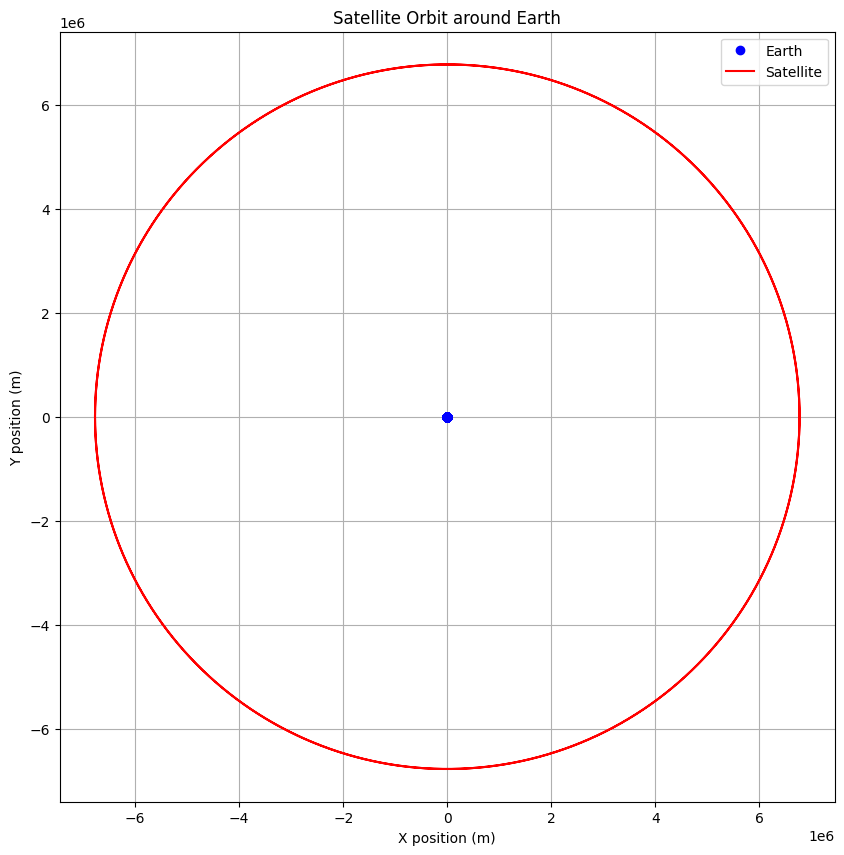

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ode_solver import *

# Earth-Satellite system parameters
G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_earth = 5.97e24  # Mass of Earth (kg)
R_earth = 6.371e6  # Radius of Earth (m)
orbit_height = 400e3  # Satellite orbit height above Earth's surface (m)

# Initial conditions
# Earth at center (0,0)
# Satellite in circular orbit
earth_x = 0
earth_y = 0
earth_vx = 0
earth_vy = 0

# Calculate orbital velocity for circular orbit
orbit_radius = R_earth + orbit_height
orbital_velocity = np.sqrt(G * M_earth / orbit_radius)
print(f"Orbital velocity: {orbital_velocity} m/s")

satellite_x = orbit_radius
satellite_y = 0
satellite_vx = 0
satellite_vy = orbital_velocity

# Combine initial conditions
y0 = np.array([earth_x, earth_y, satellite_x, satellite_y,
               earth_vx, earth_vy, satellite_vx, satellite_vy])

# Parameters dictionary
p = {
    'm': [M_earth, 1000],  # Mass of Earth and satellite (kg)
    'G': G,
    'dimension': 2,
    'fix_first': True  # Fix Earth at origin
}

# Time span for simulation (one orbital period)
orbital_period = 2 * np.pi * np.sqrt(orbit_radius**3 / (G * M_earth))
t_span = [0, orbital_period * 2]  # Simulate two orbital periods

# Solve ODE with EulerRichardson method
t, y = solve_ode(n_body, t_span, y0, EulerRichardson, p, first_step=orbital_period/1000)

# Plot the orbit
plt.figure(figsize=(10, 10))
plt.plot(y[:, 0], y[:, 1], 'bo', label='Earth')  # Earth's trajectory
plt.plot(y[:, 2], y[:, 3], 'r', label='Satellite')  # Satellite's trajectory
plt.title('Satellite Orbit around Earth')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

Orbital velocity: 4.338609156373123 EU/h


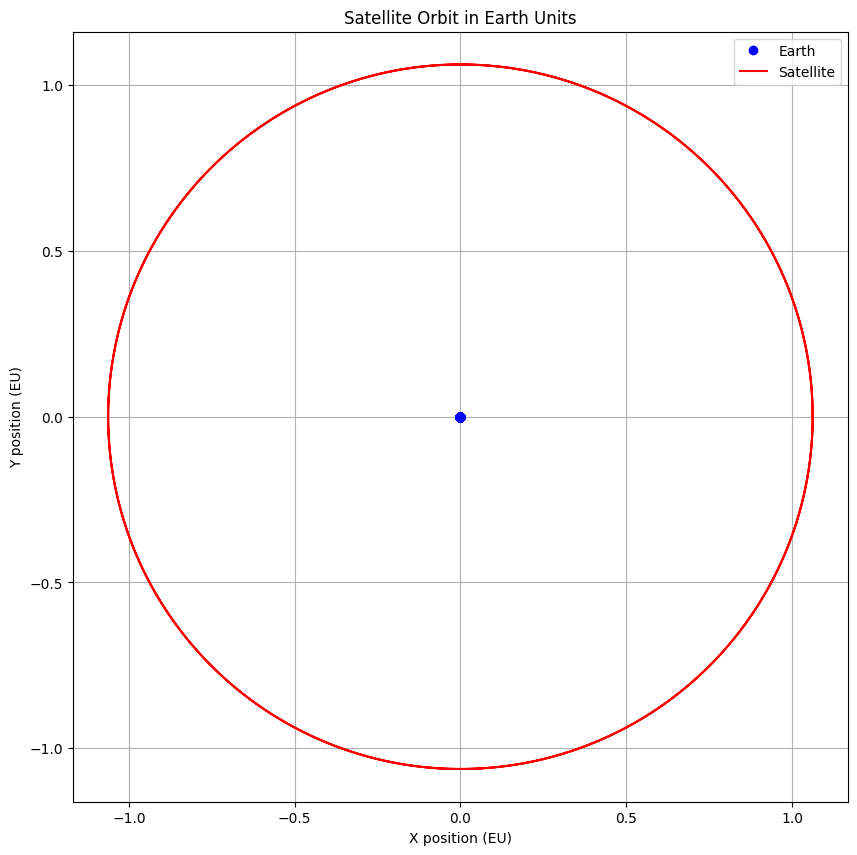

In [ ]:
# Constants in Astronomical Units
# 1 Earth Unit (EU) = radius of Earth
# 1 time unit = hours

# Gravitational constant in EU³/(h²)
G = 20.0  # Given in the problem statement

# Masses (in Earth masses)
M_earth = 1.0  # Earth is 1 in its own units
M_satellite = 0.001  # Small satellite mass

# Calculate orbital velocity for circular orbit
# Orbital radius in Earth radii
orbit_radius = 1.0 + 0.0625  # 1 EU + small increment for low orbit

# Initial conditions in Earth Units
earth_x = 0
earth_y = 0
earth_vx = 0
earth_vy = 0

# Calculate orbital velocity for circular orbit
orbital_velocity = np.sqrt(G / orbit_radius)
print(f"Orbital velocity: {orbital_velocity} EU/h")

satellite_x = orbit_radius
satellite_y = 0
satellite_vx = 0
satellite_vy = orbital_velocity

# Combine initial conditions
y0 = np.array([earth_x, earth_y, satellite_x, satellite_y,
               earth_vx, earth_vy, satellite_vx, satellite_vy])

# Parameters dictionary
p = {
    'm': [M_earth, M_satellite],
    'G': G,
    'dimension': 2,
    'fix_first': True  # Fix Earth at origin
}

# Time span for simulation (one orbital period)
orbital_period = 2 * np.pi * np.sqrt(orbit_radius**3 / G)
t_span = [0, orbital_period * 2]  # Simulate two orbital periods

# Solve ODE with EulerRichardson method
t, y = solve_ode(n_body, t_span, y0, EulerRichardson, p, first_step=orbital_period/1000)

# Plot the orbit
plt.figure(figsize=(10, 10))
plt.plot(y[:, 0], y[:, 1], 'bo', label='Earth')  # Earth's trajectory
plt.plot(y[:, 2], y[:, 3], 'r', label='Satellite')  # Satellite's trajectory
plt.title('Satellite Orbit in Earth Units')
plt.xlabel('X position (EU)')
plt.ylabel('Y position (EU)')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

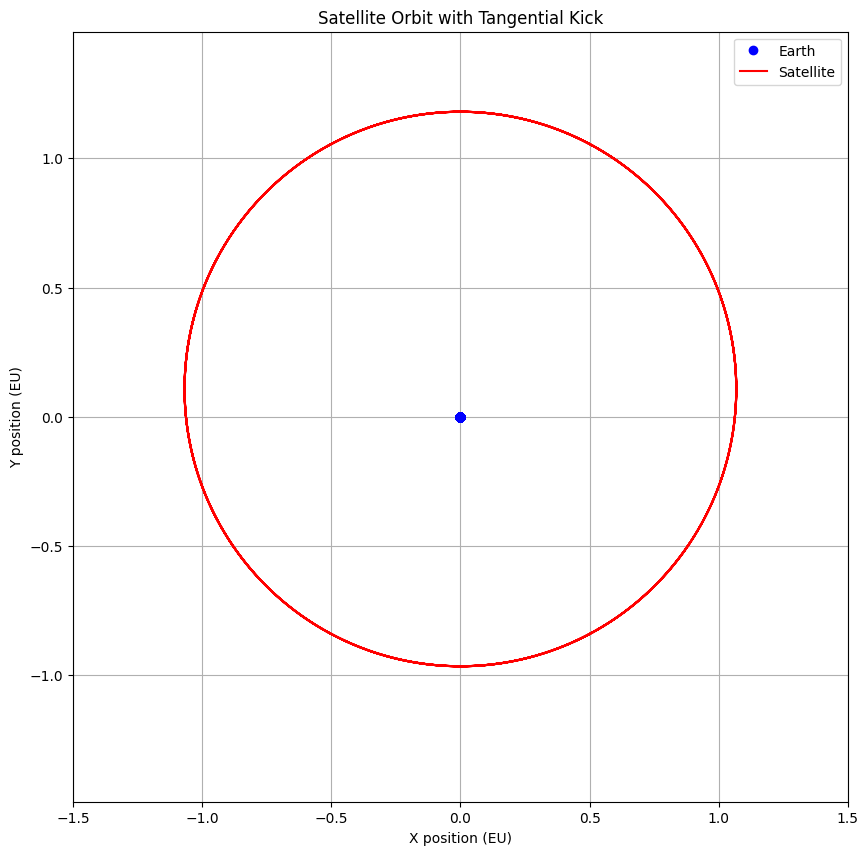

In [29]:
# Define kick strength (as a fraction of the initial velocity)
kick_strength = 0.1  # 10% increase in velocity

# Apply the kick in the tangential (x) direction
satellite_vx += kick_strength * orbital_velocity

# Update initial conditions
y0 = np.array([earth_x, earth_y, satellite_x, satellite_y,
               earth_vx, earth_vy, satellite_vx, satellite_vy])

# Solve ODE again
t, y = solve_ode(n_body, t_span, y0, EulerRichardson, p, first_step=orbital_period/1000)

# Plot the new orbit
plt.figure(figsize=(10, 10))
plt.plot(y[:, 0], y[:, 1], 'bo', label='Earth')  # Earth's trajectory
plt.plot(y[:, 2], y[:, 3], 'r', label='Satellite')  # Satellite's trajectory
plt.title('Satellite Orbit with Tangential Kick')
plt.xlabel('X position (EU)')
plt.ylabel('Y position (EU)')
plt.axis('equal')
plt.xlim(-1.5, 1.5)  # Bound X-axis
plt.ylim(-1.5, 1.5)  # Bound Y-axis
plt.legend()
plt.grid(True)
plt.show()

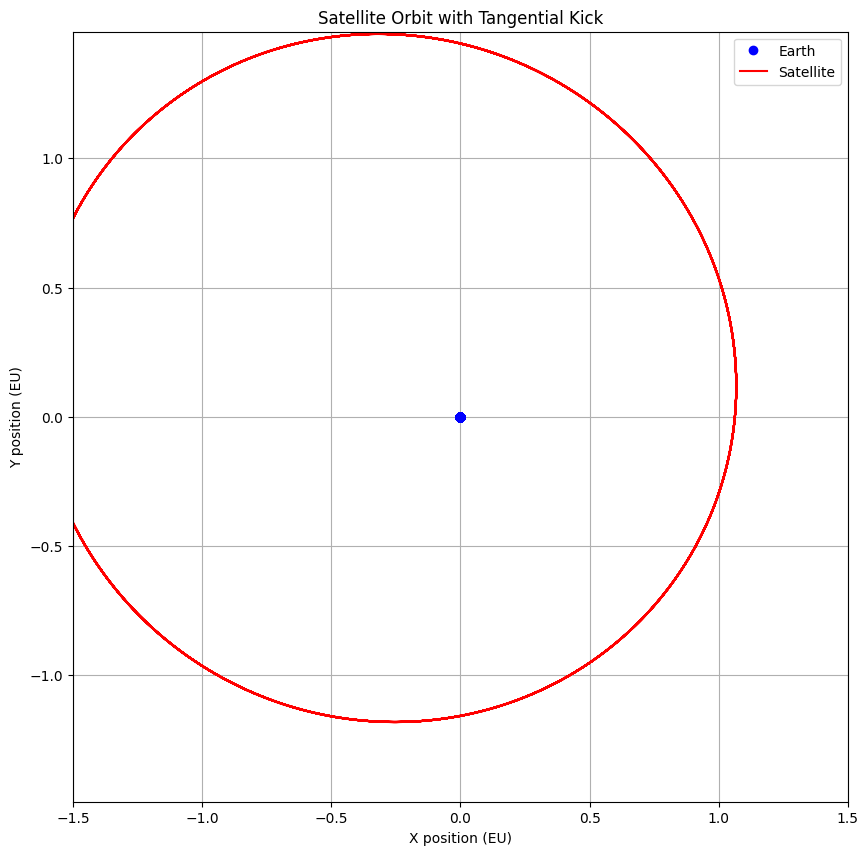

In [42]:
# Define kick strength (as a fraction of the initial velocity)
kick_strength = 0.1  # 10% increase in velocity

# Apply the kick in the tangential (y) direction
satellite_vy += kick_strength * orbital_velocity

# Update initial conditions
y0 = np.array([earth_x, earth_y, satellite_x, satellite_y,
               earth_vx, earth_vy, satellite_vx, satellite_vy])

# Solve ODE again
t, y = solve_ode(n_body, t_span, y0, EulerRichardson, p, first_step=orbital_period/1000)

# Plot the new orbit
plt.figure(figsize=(10, 10))
plt.plot(y[:, 0], y[:, 1], 'bo', label='Earth')  # Earth's trajectory
plt.plot(y[:, 2], y[:, 3], 'r', label='Satellite')  # Satellite's trajectory
plt.title('Satellite Orbit with Tangential Kick')
plt.xlabel('X position (EU)')
plt.ylabel('Y position (EU)')
plt.axis('equal')
plt.xlim(-1.5, 1.5)  # Bound X-axis
plt.ylim(-1.5, 1.5)  # Bound Y-axis
plt.legend()
plt.grid(True)
plt.show()

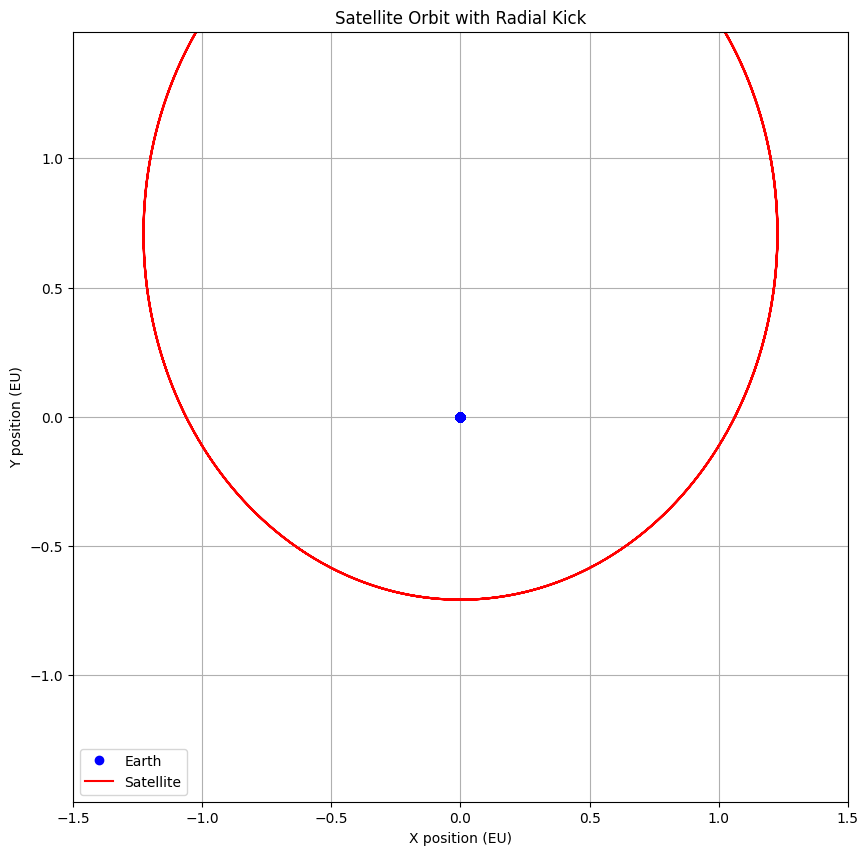

In [26]:
# Define kick strength (as a fraction of the initial orbital velocity)
kick_strength = 0.1  # 10% of orbital velocity

# Apply the kick in the radial (x) direction
satellite_vx += kick_strength * orbital_velocity  # Positive kick (away from Earth)

# Update initial conditions
y0 = np.array([earth_x, earth_y, satellite_x, satellite_y,
               earth_vx, earth_vy, satellite_vx, satellite_vy])

# Solve ODE again
t, y = solve_ode(n_body, t_span, y0, EulerRichardson, p, first_step=orbital_period/1000)

# Plot the new orbit
plt.figure(figsize=(10, 10))
plt.plot(y[:, 0], y[:, 1], 'bo', label='Earth')  # Earth's trajectory
plt.plot(y[:, 2], y[:, 3], 'r', label='Satellite')  # Satellite's trajectory
plt.title('Satellite Orbit with Radial Kick')
plt.xlabel('X position (EU)')
plt.ylabel('Y position (EU)')
plt.axis('equal')
plt.xlim(-1.5, 1.5)  # Bound X-axis
plt.ylim(-1.5, 1.5)  # Bound Y-axis
plt.legend()
plt.grid(True)
plt.show()

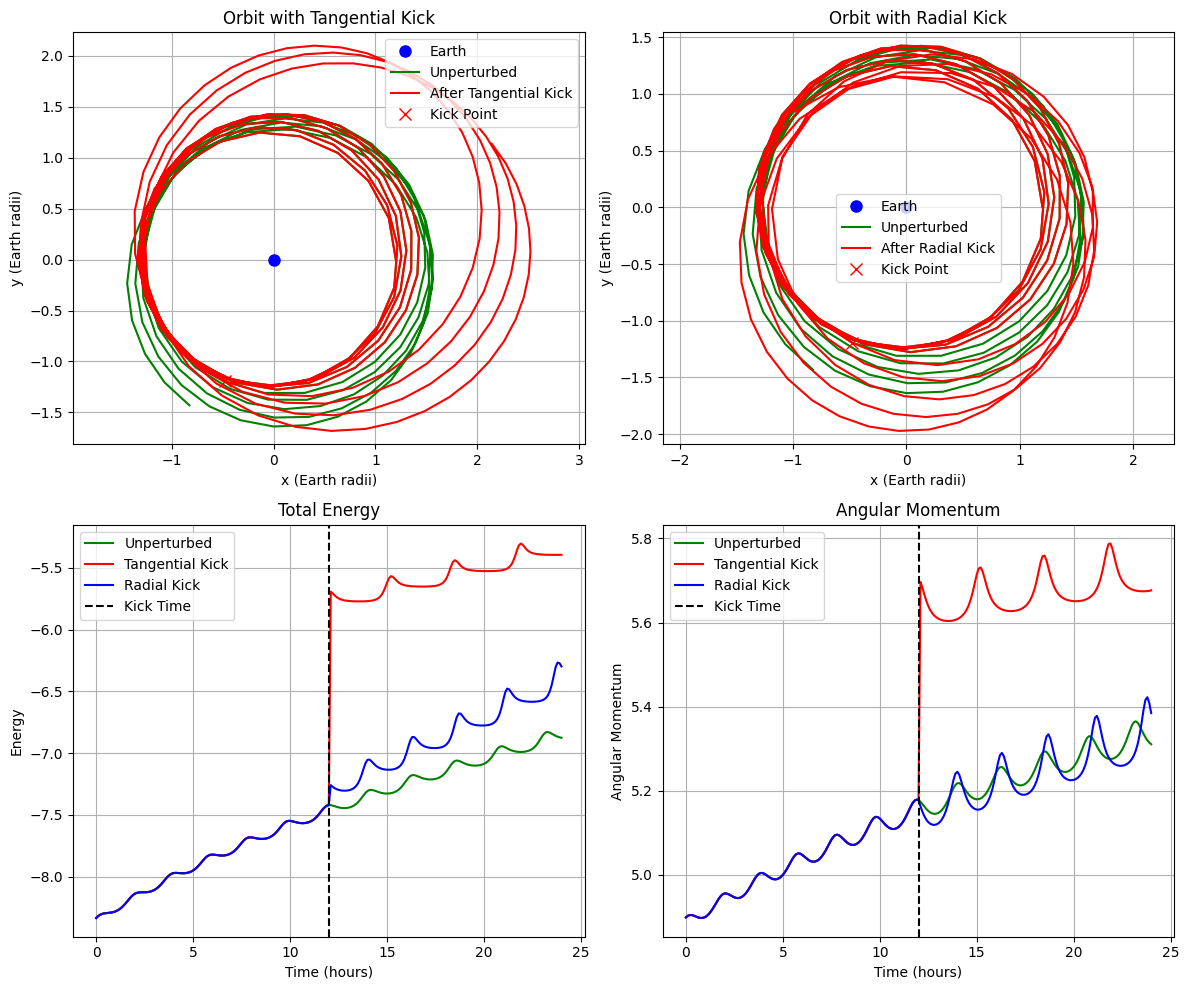

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Using the provided solve_ode and n_body functions
# First, let's define a function for a satellite orbiting Earth

def satellite_force(t, x, p):
    """
    ODE function for a satellite orbiting Earth.

    Parameters:
    t (float): time (unused but required for ODE solver compatibility)
    x (np.array): state vector [x, vx, y, vy]
    p (dict): parameters dictionary containing:
        - Gm (float): gravitational parameter (G*m)

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # Extract position
    pos_x, vel_x, pos_y, vel_y = x

    # Calculate distance from Earth (at origin)
    r = np.sqrt(pos_x**2 + pos_y**2)

    # Initialize derivative vector [vx, ax, vy, ay]
    dxdt = np.zeros_like(x)

    # First half of dxdt is just the velocities
    dxdt[0] = vel_x
    dxdt[2] = vel_y

    # Calculate accelerations (Earth is at origin)
    if r > 0:  # Avoid division by zero
        # Gravitational acceleration
        acc = -p['Gm'] / (r**3)
        dxdt[1] = acc * pos_x
        dxdt[3] = acc * pos_y

    return dxdt

# Earth units parameters
Gm_earth = 20.0  # Gravitational parameter in earth units (EU³/h²)

# Function to apply kick
def apply_kick(state, kick_magnitude, is_tangential=True):
    """
    Apply a kick (impulse) to the satellite.

    Parameters:
    state (np.array): Current state [x, vx, y, vy]
    kick_magnitude (float): Magnitude of the kick
    is_tangential (bool): If True, tangential kick; if False, radial kick

    Returns:
    np.array: New state after kick
    """
    x, vx, y, vy = state
    r = np.sqrt(x**2 + y**2)

    # Unit vectors
    if r > 0:
        # Radial unit vector (pointing from Earth to satellite)
        rx, ry = x/r, y/r

        # Tangential unit vector (perpendicular to radial)
        tx, ty = -ry, rx  # 90 degrees counter-clockwise rotation

        # Apply kick
        if is_tangential:
            # Tangential kick
            vx += kick_magnitude * tx
            vy += kick_magnitude * ty
        else:
            # Radial kick
            vx += kick_magnitude * rx
            vy += kick_magnitude * ry

    return np.array([x, vx, y, vy])

# Set up simulation parameters
t_span = [0, 24]  # 24 hours simulation
dt = 0.1  # time step

# Initial circular orbit
radius = 1.2  # Earth radii
circular_velocity = np.sqrt(Gm_earth / radius)

# Initial state: [x, vx, y, vy]
y0 = np.array([radius, 0, 0, circular_velocity])

# Parameters dictionary
p = {'Gm': Gm_earth}

# Run simulation for unperturbed orbit first
t_unperturbed, y_unperturbed = solve_ode(satellite_force, t_span, y0, EulerRichardson, p, first_step=dt)

# Apply tangential kick at t = 12h (after one orbit)
kick_time = 12  # hours
kick_magnitude = 0.1 * circular_velocity  # 10% of circular velocity

# Find the index closest to kick_time
kick_index = np.argmin(np.abs(t_unperturbed - kick_time))

# Copy states up to kick time
t_tangential = t_unperturbed[:kick_index+1].copy()
y_tangential = y_unperturbed[:kick_index+1].copy()

# Apply tangential kick and continue simulation
kicked_state = apply_kick(y_tangential[-1], kick_magnitude, is_tangential=True)
remaining_t_span = [t_tangential[-1], t_span[1]]
t_remaining, y_remaining = solve_ode(satellite_force, remaining_t_span, kicked_state, EulerRichardson, p, first_step=dt)

# Combine results
t_tangential = np.concatenate([t_tangential, t_remaining[1:]])
y_tangential = np.vstack([y_tangential, y_remaining[1:]])

# Similarly for radial kick
t_radial = t_unperturbed[:kick_index+1].copy()
y_radial = y_unperturbed[:kick_index+1].copy()

kicked_state_radial = apply_kick(y_radial[-1], kick_magnitude, is_tangential=False)
t_remaining, y_remaining = solve_ode(satellite_force, remaining_t_span, kicked_state_radial, EulerRichardson, p, first_step=dt)

t_radial = np.concatenate([t_radial, t_remaining[1:]])
y_radial = np.vstack([y_radial, y_remaining[1:]])

# Plot results
plt.figure(figsize=(12, 10))

# Plot orbits
plt.subplot(221)
plt.plot(0, 0, 'bo', markersize=8, label='Earth')  # Earth at origin
plt.plot(y_unperturbed[:, 0], y_unperturbed[:, 2], 'g-', label='Unperturbed')
plt.plot(y_tangential[:, 0], y_tangential[:, 2], 'r-', label='After Tangential Kick')
plt.plot(y_tangential[kick_index, 0], y_tangential[kick_index, 2], 'rx', markersize=8, label='Kick Point')
plt.grid(True)
plt.xlabel('x (Earth radii)')
plt.ylabel('y (Earth radii)')
plt.title('Orbit with Tangential Kick')
plt.axis('equal')
plt.legend()

plt.subplot(222)
plt.plot(0, 0, 'bo', markersize=8, label='Earth')  # Earth at origin
plt.plot(y_unperturbed[:, 0], y_unperturbed[:, 2], 'g-', label='Unperturbed')
plt.plot(y_radial[:, 0], y_radial[:, 2], 'r-', label='After Radial Kick')
plt.plot(y_radial[kick_index, 0], y_radial[kick_index, 2], 'rx', markersize=8, label='Kick Point')
plt.grid(True)
plt.xlabel('x (Earth radii)')
plt.ylabel('y (Earth radii)')
plt.title('Orbit with Radial Kick')
plt.axis('equal')
plt.legend()

# Calculate energy and angular momentum
def calculate_energy(state, p):
    x, vx, y, vy = state
    r = np.sqrt(x**2 + y**2)
    kinetic = 0.5 * (vx**2 + vy**2)
    potential = -p['Gm'] / r
    return kinetic + potential

def calculate_angular_momentum(state):
    x, vx, y, vy = state
    return x*vy - y*vx

# Energy before and after kicks
E_unperturbed = np.array([calculate_energy(state, p) for state in y_unperturbed])
E_tangential = np.array([calculate_energy(state, p) for state in y_tangential])
E_radial = np.array([calculate_energy(state, p) for state in y_radial])

# Angular momentum before and after kicks
L_unperturbed = np.array([calculate_angular_momentum(state) for state in y_unperturbed])
L_tangential = np.array([calculate_angular_momentum(state) for state in y_tangential])
L_radial = np.array([calculate_angular_momentum(state) for state in y_radial])

# Plot energy
plt.subplot(223)
plt.plot(t_unperturbed, E_unperturbed, 'g-', label='Unperturbed')
plt.plot(t_tangential, E_tangential, 'r-', label='Tangential Kick')
plt.plot(t_radial, E_radial, 'b-', label='Radial Kick')
plt.axvline(x=kick_time, color='k', linestyle='--', label='Kick Time')
plt.grid(True)
plt.xlabel('Time (hours)')
plt.ylabel('Energy')
plt.title('Total Energy')
plt.legend()

# Plot angular momentum
plt.subplot(224)
plt.plot(t_unperturbed, L_unperturbed, 'g-', label='Unperturbed')
plt.plot(t_tangential, L_tangential, 'r-', label='Tangential Kick')
plt.plot(t_radial, L_radial, 'b-', label='Radial Kick')
plt.axvline(x=kick_time, color='k', linestyle='--', label='Kick Time')
plt.grid(True)
plt.xlabel('Time (hours)')
plt.ylabel('Angular Momentum')
plt.title('Angular Momentum')
plt.legend()

plt.tight_layout()
plt.show()

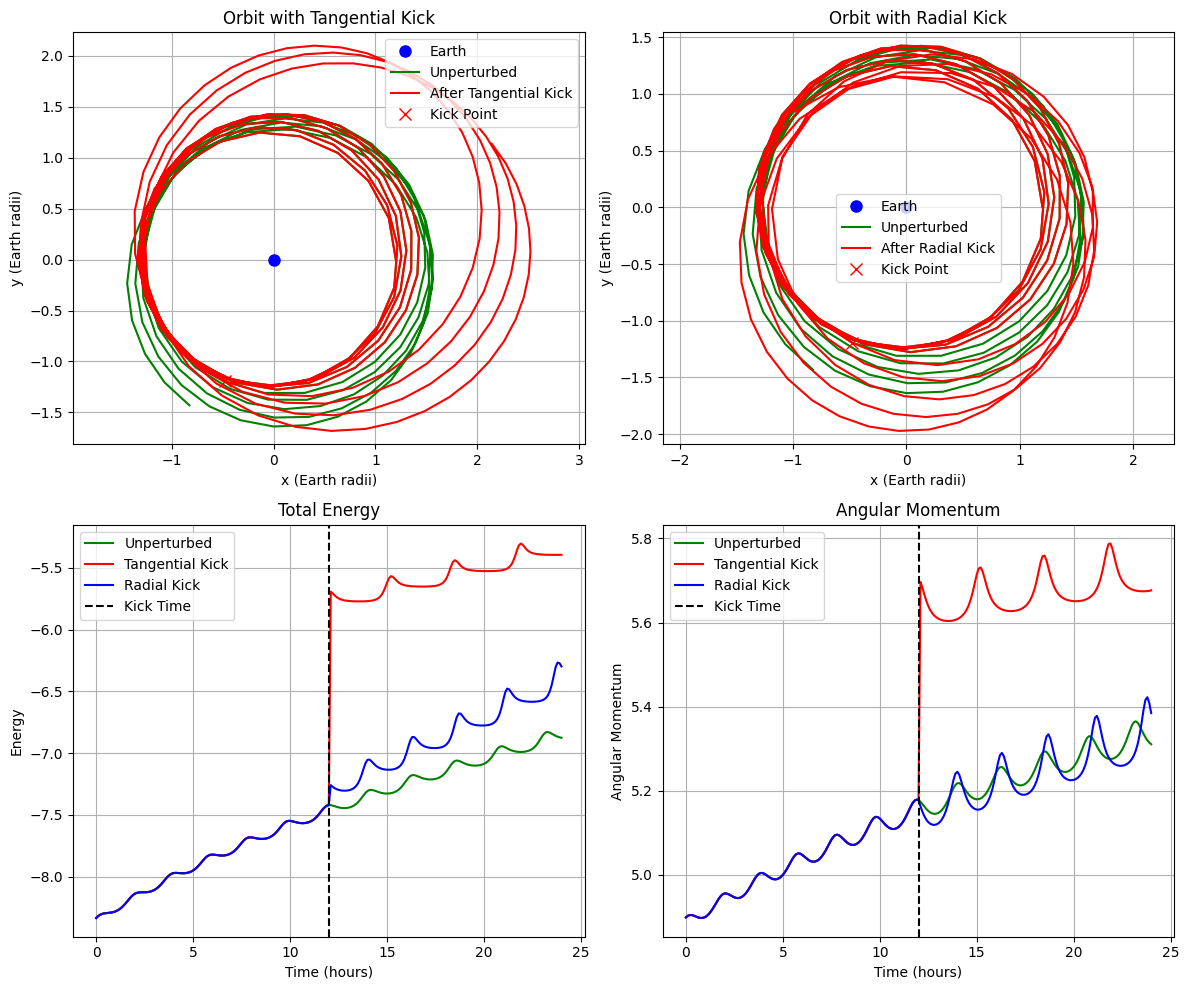

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to apply kick to the satellite
def apply_kick(state, kick_magnitude, is_tangential=True):
    """
    Apply a kick (impulse) to the satellite.

    Parameters:
    state (np.array): Current state [x1,y1,x2,y2,vx1,vy1,vx2,vy2]
                     where body 1 is Earth (fixed) and body 2 is the satellite
    kick_magnitude (float): Magnitude of the kick
    is_tangential (bool): If True, tangential kick; if False, radial kick

    Returns:
    np.array: New state after kick
    """
    # Earth is at position (state[0], state[1])
    earth_x, earth_y = state[0], state[1]

    # Satellite position and velocity
    sat_x, sat_y = state[2], state[3]
    sat_vx, sat_vy = state[6], state[7]

    # Calculate relative position (satellite - Earth)
    rel_x = sat_x - earth_x
    rel_y = sat_y - earth_y

    # Calculate distance
    r = np.sqrt(rel_x**2 + rel_y**2)

    # Create new state to modify (don't modify original)
    new_state = state.copy()

    if r > 0:
        # Radial unit vector (pointing from Earth to satellite)
        rx, ry = rel_x/r, rel_y/r

        # Tangential unit vector (perpendicular to radial)
        tx, ty = -ry, rx  # 90 degrees counter-clockwise rotation

        # Apply kick (only to satellite velocities)
        if is_tangential:
            # Tangential kick
            new_state[6] += kick_magnitude * tx
            new_state[7] += kick_magnitude * ty
        else:
            # Radial kick
            new_state[6] += kick_magnitude * rx
            new_state[7] += kick_magnitude * ry

    return new_state

# Set up simulation parameters
t_span = [0, 24]  # 24 hours simulation
dt = 0.1  # time step

# Earth parameters
G = 20.0  # Gravitational parameter in earth units (EU³/h²)

# Parameters dictionary for n_body
p = {
    'm': [1.0, 0.001],  # masses (Earth, satellite)
    'G': G,
    'dimension': 2,
    'fix_first': True   # Earth is fixed
}

# Initial circular orbit
radius = 1.2  # Earth radii
circular_velocity = np.sqrt(G / radius)

# Initial state: [x1,y1,x2,y2,vx1,vy1,vx2,vy2]
# Earth at origin with zero velocity
# Satellite at (radius, 0) with velocity (0, circular_velocity)
y0 = np.array([0, 0, radius, 0, 0, 0, 0, circular_velocity])

# Run simulation for unperturbed orbit first
t_unperturbed, y_unperturbed = solve_ode(n_body, t_span, y0, EulerRichardson, p, first_step=dt)

# Apply tangential kick at t = 12h (after one orbit)
kick_time = 12  # hours
kick_magnitude = 0.1 * circular_velocity  # 10% of circular velocity

# Find the index closest to kick_time
kick_index = np.argmin(np.abs(t_unperturbed - kick_time))

# Copy states up to kick time
t_tangential = t_unperturbed[:kick_index+1].copy()
y_tangential = y_unperturbed[:kick_index+1].copy()

# Apply tangential kick and continue simulation
kicked_state = apply_kick(y_tangential[-1], kick_magnitude, is_tangential=True)
remaining_t_span = [t_tangential[-1], t_span[1]]
t_remaining, y_remaining = solve_ode(n_body, remaining_t_span, kicked_state, EulerRichardson, p, first_step=dt)

# Combine results
t_tangential = np.concatenate([t_tangential, t_remaining[1:]])
y_tangential = np.vstack([y_tangential, y_remaining[1:]])
# y_tangential = np.concatenate((y_tangential, y_remaining[1:]), axis=0) -- concatenate arrays vertically


# Similarly for radial kick
t_radial = t_unperturbed[:kick_index+1].copy()
y_radial = y_unperturbed[:kick_index+1].copy()

kicked_state_radial = apply_kick(y_radial[-1], kick_magnitude, is_tangential=False)
t_remaining, y_remaining = solve_ode(n_body, remaining_t_span, kicked_state_radial, EulerRichardson, p, first_step=dt)

t_radial = np.concatenate([t_radial, t_remaining[1:]])
y_radial = np.vstack([y_radial, y_remaining[1:]])

# Calculate energy and angular momentum
def calculate_energy(state, p):
    # Earth is at origin
    earth_x, earth_y = state[0], state[1]

    # Satellite position and velocity
    sat_x, sat_y = state[2], state[3]
    sat_vx, sat_vy = state[6], state[7]

    # Calculate relative position and distance
    rel_x = sat_x - earth_x
    rel_y = sat_y - earth_y
    r = np.sqrt(rel_x**2 + rel_y**2)

    # Calculate energy components (per unit mass of satellite)
    kinetic = 0.5 * (sat_vx**2 + sat_vy**2)
    potential = -p['G'] * p['m'][0] / r

    return kinetic + potential

def calculate_angular_momentum(state):
    # Earth is at origin
    earth_x, earth_y = state[0], state[1]

    # Satellite position and velocity
    sat_x, sat_y = state[2], state[3]
    sat_vx, sat_vy = state[6], state[7]

    # Calculate relative position
    rel_x = sat_x - earth_x
    rel_y = sat_y - earth_y

    # Angular momentum per unit mass
    return rel_x*sat_vy - rel_y*sat_vx

# Calculate energy and angular momentum for each trajectory
E_unperturbed = np.array([calculate_energy(state, p) for state in y_unperturbed])
E_tangential = np.array([calculate_energy(state, p) for state in y_tangential])
E_radial = np.array([calculate_energy(state, p) for state in y_radial])

L_unperturbed = np.array([calculate_angular_momentum(state) for state in y_unperturbed])
L_tangential = np.array([calculate_angular_momentum(state) for state in y_tangential])
L_radial = np.array([calculate_angular_momentum(state) for state in y_radial])

# Plot results
plt.figure(figsize=(12, 10))

# Plot orbits
plt.subplot(221)
plt.plot(0, 0, 'bo', markersize=8, label='Earth')  # Earth at origin
plt.plot(y_unperturbed[:, 2], y_unperturbed[:, 3], 'g-', label='Unperturbed')
plt.plot(y_tangential[:, 2], y_tangential[:, 3], 'r-', label='After Tangential Kick')
plt.plot(y_tangential[kick_index, 2], y_tangential[kick_index, 3], 'rx', markersize=8, label='Kick Point')
plt.grid(True)
plt.xlabel('x (Earth radii)')
plt.ylabel('y (Earth radii)')
plt.title('Orbit with Tangential Kick')
plt.axis('equal')
plt.legend()

plt.subplot(222)
plt.plot(0, 0, 'bo', markersize=8, label='Earth')  # Earth at origin
plt.plot(y_unperturbed[:, 2], y_unperturbed[:, 3], 'g-', label='Unperturbed')
plt.plot(y_radial[:, 2], y_radial[:, 3], 'r-', label='After Radial Kick')
plt.plot(y_radial[kick_index, 2], y_radial[kick_index, 3], 'rx', markersize=8, label='Kick Point')
plt.grid(True)
plt.xlabel('x (Earth radii)')
plt.ylabel('y (Earth radii)')
plt.title('Orbit with Radial Kick')
plt.axis('equal')
plt.legend()

# Plot energy
plt.subplot(223)
plt.plot(t_unperturbed, E_unperturbed, 'g-', label='Unperturbed')
plt.plot(t_tangential, E_tangential, 'r-', label='Tangential Kick')
plt.plot(t_radial, E_radial, 'b-', label='Radial Kick')
plt.axvline(x=kick_time, color='k', linestyle='--', label='Kick Time')
plt.grid(True)
plt.xlabel('Time (hours)')
plt.ylabel('Energy')
plt.title('Total Energy')
plt.legend()

# Plot angular momentum
plt.subplot(224)
plt.plot(t_unperturbed, L_unperturbed, 'g-', label='Unperturbed')
plt.plot(t_tangential, L_tangential, 'r-', label='Tangential Kick')
plt.plot(t_radial, L_radial, 'b-', label='Radial Kick')
plt.axvline(x=kick_time, color='k', linestyle='--', label='Kick Time')
plt.grid(True)
plt.xlabel('Time (hours)')
plt.ylabel('Angular Momentum')
plt.title('Angular Momentum')
plt.legend()

plt.tight_layout()
plt.show()